In [1]:
%run ./rc.ipynb

In [2]:
from __future__ import annotations

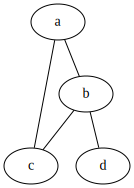

In [3]:
%%dot
graph {
    a -- { b c }
    b -- c
    b -- d
}

In [4]:
from dataclasses import field

@dataclass(eq=True, frozen=True)
class Graph:
    graph: dict[str, set[str]]

    def __getattr__(self, key):
        # ignore ipython inspection
        if key.startswith('_'):
            return None

        if key not in self.graph:
            self.graph[key] = set()

        return Node(key, self)

    def get(self, key, default=None):
        if key in self.graph:
            return Node(key, self)
        else:
            return default

    def connect(self, ida, idb):
        self.graph[ida].add(idb)
        self.graph[idb].add(ida)
        return self

    def __iter__(self):
        yield from map(self.get, self.graph.keys())

    def __len__(self):
        return len(self.graph)

    def __repr__(self):
        lines = ['strict graph {']
        for id, adjs in self.graph.items():
            lines.append(f'  {id} -- ' + '{ ' + " ".join(adjs) + ' }')
        lines.append('}')
        return '\n'.join(lines)

    def _repr_svg_(self):
        def run_graphviz(s, layout_engine='dot'):
            import codecs
            from subprocess import Popen, PIPE

            """Execute dot with a layout and return a raw SVG image, or None."""
            cmd = ['dot', '-Tsvg', '-K', layout_engine]

            dot = Popen(cmd, stdin=PIPE, stdout=PIPE, stderr=PIPE)
            stdoutdata, stderrdata = dot.communicate(s.encode('utf-8'))
            status = dot.wait()
            if status == 0:
                return stdoutdata
            else:
                fstr = "dot returned {}\n[==== stderr ====]\n{}"
                error(fstr.format(status, stderrdata.decode('utf-8')))
                return None
        return run_graphviz(repr(self)).decode('utf-8')



@dataclass(eq=True, frozen=True)
class Node:
    id: str
    graph: Graph

    def __sub__(self, other):
        return self.graph.connect(self.id, other.id)

    def adjacent(self):
        return [self.graph.get(id) for id in self.graph.graph[self.id]]

    def __repr__(self):
        return f'( {self.id} )'

In [5]:
def dfs(node, target, seen):
    print(node)
    if node.id == target.id:
        return f'{target.id}'
    else:
        seen.update(node.id)

        for adj in node.adjacent():
            if adj.id not in seen:
                if found := dfs(adj, target, seen):
                    return f'{node.id} -> {found}'
        return ''

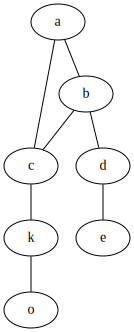

In [6]:
g = Graph({})
g.a - g.b
g.a - g.c
g.b - g.c
g.c - g.k
g.k - g.o
g.b - g.d
g.d - g.e

In [7]:
arr = [1, 2, 3]
arr

[1, 2, 3]

In [30]:
def bfs(initial, target):
    seen = { initial.id: initial.id }
    queue = [initial]

    while len(queue):
        parent = queue.pop(0)

        for child in parent.adjacent():
            if child.id == target.id:
                acc = f'{target.id}'
                i = parent.id
                while i != initial.id:
                    acc = i + ' -> ' + acc
                    i = seen[i]
                return initial.id + ' -> ' + acc

            if not seen.get(child.id, None):
                seen[child.id] = parent.id
                queue.append(child)

In [31]:
dfs(g.a, g.o, set())

( a )
( b )
( d )
( e )
( c )
( k )
( o )


'a -> b -> c -> k -> o'

In [32]:
bfs(g.a, g.o)

'a -> c -> k -> o'

In [25]:
g.b.adjacent()

[( a ), ( d ), ( c )]

In [37]:
from collections import OrderedDict

In [41]:
try:
    from functools import reduce
except:
    pass
 
data = OrderedDict({
    'des_system_lib':   set('std synopsys std_cell_lib des_system_lib dw02 dw01 ramlib ieee'.split()),
    'dw01':             set('ieee dw01 dware gtech'.split()),
    'dw02':             set('ieee dw02 dware'.split()),
    'dw03':             set('std synopsys dware dw03 dw02 dw01 ieee gtech'.split()),
    'dw04':             set('dw04 ieee dw01 dware gtech'.split()),
    'dw05':             set('dw05 ieee dware'.split()),
    'dw06':             set('dw06 ieee dware'.split()),
    'dw07':             set('ieee dware'.split()),
    'dware':            set('ieee dware'.split()),
    'gtech':            set('ieee gtech'.split()),
    'ramlib':           set('std ieee'.split()),
    'std_cell_lib':     set('ieee std_cell_lib'.split()),
    'synopsys':         set(),
    })
 
def toposort2(data):
    for k, v in data.items():
        v.discard(k) # Ignore self dependencies
    extra_items_in_deps = reduce(set.union, data.values()) - set(data.keys())
    data.update({item:set() for item in extra_items_in_deps})
    while True:
        ordered = set(item for item,dep in data.items() if not dep)
        if not ordered:
            break
        yield ' '.join(sorted(ordered))
        data = {item: (dep - ordered) for item,dep in data.items()
                if item not in ordered}
    assert not data, "A cyclic dependency exists amongst %r" % data
 
print ('\n'.join( toposort2(data) ))


ieee std synopsys
dware gtech ramlib std_cell_lib
dw01 dw02 dw05 dw06 dw07
des_system_lib dw03 dw04


In [42]:
data

OrderedDict([('des_system_lib',
              {'dw01',
               'dw02',
               'ieee',
               'ramlib',
               'std',
               'std_cell_lib',
               'synopsys'}),
             ('dw01', {'dware', 'gtech', 'ieee'}),
             ('dw02', {'dware', 'ieee'}),
             ('dw03',
              {'dw01', 'dw02', 'dware', 'gtech', 'ieee', 'std', 'synopsys'}),
             ('dw04', {'dw01', 'dware', 'gtech', 'ieee'}),
             ('dw05', {'dware', 'ieee'}),
             ('dw06', {'dware', 'ieee'}),
             ('dw07', {'dware', 'ieee'}),
             ('dware', {'ieee'}),
             ('gtech', {'ieee'}),
             ('ramlib', {'ieee', 'std'}),
             ('std_cell_lib', {'ieee'}),
             ('synopsys', set()),
             ('std', set()),
             ('ieee', set())])

In [ ]:
def topo(g):
    seen = set()
    acc = [0] * len(g)
    i = len(g) - 1
    for node in g:
        if node not in seen:
            i = dfs(node, i, seen, acc, g)
    return acc

def dfs(node, i, seen, acc, g):
    for child 